# Recurrent Neural Networks (RNN)

In this lesson we will learn how to process sequential data (sentences, time-series, etc.) with recurrent neural networks (RNNs). 

<div align="left">
<a href="https://github.com/madewithml/basics/blob/master/notebooks/15_Recurrent_Neural_Networks/15_TF_Recurrent_Neural_Networks.ipynb" role="button"><img class="notebook-badge-image" src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/madewithml/basics/blob/master/notebooks/15_Recurrent_Neural_Networks/15_TF_Recurrent_Neural_Networks.ipynb"><img class="notebook-badge-image" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

So far we've processed inputs as whole (ex. applying filters across the entire input to extract features) but we can also processed our inputs sequentially. To illustrate what this looks like, suppose our inputs are sentences (like the news dataset inputs we've seen in previous lessons). Think of each word/puncutation (or token) in the sentence as a timestep. So a sentence with 8 tokens has 8 timesteps. We can process each timestep, one at a time, and predict the class after the last timestep (token) has been processed. This is very powerful because the model now has a meaningful way to account for the order in our sequence and predict accordingly. 

# Overview

* **Objective:**  Process sequential data by accounting for the currend input and also what has been learned from previous inputs.
* **Advantages:** 
    * Account for order and previous inputs in a meaningful way.
    * Conditioned generation for generating sequences.
* **Disadvantages:** 
    * Each time step's prediction depends on the previous prediction so it's difficult to parallelize RNN operations. 
    * Processing long sequences can yield memory and computation issues.
    * Interpretability is difficult but there are few [techniques](https://arxiv.org/abs/1506.02078) that use the activations from RNNs to see what parts of the inputs are processed. 
* **Miscellaneous:** 
    * Architectural tweaks to make RNNs faster and interpretable is an ongoing area of research.

# Data

## Load data

We will download the [AG News dataset](http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html), which consists of 120000 text samples from 4 unique classes ('Business', 'Sci/Tech', 'Sports', 'World')

In [0]:
import numpy as np
import pandas as pd
import re
import urllib

In [0]:
SEED = 1234
DATA_FILE = 'news.csv'
INPUT_FEATURE = 'title'
OUTPUT_FEATURE = 'category'

In [0]:
# Set seed for reproducibility
np.random.seed(SEED)

In [0]:
# Load data from GitHub to this notebook's local drive
url = "https://raw.githubusercontent.com/madewithml/basics/master/data/news.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(DATA_FILE, 'wb') as fp:
    fp.write(html)

In [0]:
# Load data
df = pd.read_csv(DATA_FILE, header=0)
X = df[INPUT_FEATURE].values
y = df[OUTPUT_FEATURE].values
df.head(5)

,title,category
0,Wall St. Bears Claw Back Into the Black (Reuters),Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters),Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,Business
4,"Oil prices soar to all-time record, posing new...",Business


## Split data

In [0]:
import collections
from sklearn.model_selection import train_test_split

In [0]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SHUFFLE = True

In [0]:
def train_val_test_split(X, y, val_size, test_size, shuffle):
    """Split data into train/val/test datasets.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, shuffle=shuffle)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, stratify=y_train, shuffle=shuffle)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [0]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, val_size=VAL_SIZE, test_size=TEST_SIZE, shuffle=SHUFFLE)
class_counts = dict(collections.Counter(y))
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")
print (f"Classes: {class_counts}")

X_train: (86700,), y_train: (86700,)
X_val: (15300,), y_val: (15300,)
X_test: (18000,), y_test: (18000,)
Sample point: PGA overhauls system for Ryder Cup points → Sports
Classes: {'Business': 30000, 'Sci/Tech': 30000, 'Sports': 30000, 'World': 30000}


## Tokenizer

In [0]:
# Use TF 2.0 (not 2.1) because of an issue with tf.gather_nd with generators...
!pip install tensorflow==2.0

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import urllib
print (f"tf version: {tf.__version__}")
print("GPU Available: ", tf.test.is_gpu_available('GPU'))

tf version: 2.0.0
GPU Available:  False


In [0]:
FILTERS = "!\"'#$%&()*+,-./:;<=>?@[\\]^_`{|}~"
LOWER = True
CHAR_LEVEL = False

In [0]:
def decode(indices, tokenizer):
    """Decode a list of indices into string."""
    return " ".join([tokenizer.index_word[index] for index in indices])

In [0]:
# Input vectorizer
X_tokenizer = Tokenizer(
    filters=FILTERS, lower=LOWER, char_level=CHAR_LEVEL, oov_token='<UNK>')

In [0]:
# Fit only on train data
X_tokenizer.fit_on_texts(X_train)
vocab_size = len(X_tokenizer.word_index) + 1
print (f"# tokens: {vocab_size}")

# tokens: 29782


In [0]:
# Convert text to sequence of tokens
original_text = X_train[0]
X_train = np.array(X_tokenizer.texts_to_sequences(X_train))
X_val = np.array(X_tokenizer.texts_to_sequences(X_val))
X_test = np.array(X_tokenizer.texts_to_sequences(X_test))
preprocessed_text = decode(X_train[0], X_tokenizer)
print (f"{original_text} \n\t→ {preprocessed_text} \n\t→ {X_train[0]}")

PGA overhauls system for Ryder Cup points 
	→ pga overhauls system for ryder cup points 
	→ [2013, 7327, 467, 5, 702, 118, 1137]


## LabelEncoder

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
# Output vectorizer
y_tokenizer = LabelEncoder()

In [0]:
# Fit on train data
y_tokenizer = y_tokenizer.fit(y_train)
classes = list(y_tokenizer.classes_)
print (f"classes: {classes}")

classes: ['Business', 'Sci/Tech', 'Sports', 'World']


In [0]:
# Convert labels to tokens
y_train = y_tokenizer.transform(y_train)
y_val = y_tokenizer.transform(y_val)
y_test = y_tokenizer.transform(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: 2


In [0]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [21675 21675 21675 21675],
class weights: {0: 4.61361014994233e-05, 1: 4.61361014994233e-05, 2: 4.61361014994233e-05, 3: 4.61361014994233e-05}


## Generators

In [0]:
import math
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence

In [0]:
BATCH_SIZE = 256

In [0]:
class DataGenerator(Sequence):
    """Custom data loader."""
    def __init__(self, X, y, batch_size, shuffle=False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """# of batches."""
        return math.ceil(len(self.X) / self.batch_size)

    def __str__(self):
        return (f"<DataGenerator(" \
                f"batch_size={self.batch_size}, " \
                f"batches={len(self)}, " \
                f"shuffle={self.shuffle})>")

    def __getitem__(self, index):
        """Generate a batch."""

        # Gather indices for this batch
        batch_indices = self.epoch_indices[index*self.batch_size:(index+1)*self.batch_size]

        # Generate batch data
        inputs, outputs = self.create_batch(batch_indices=batch_indices)

        return inputs, outputs

    def on_epoch_end(self):
        """Create indices after each epoch."""
        self.epoch_indices = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.epoch_indices)

    def create_batch(self, batch_indices):
        """Generate data from indices."""
        X = self.X[batch_indices]
        y = self.y[batch_indices]
        
        # Sequence lengths
        seq_lengths = np.array([[i, len(x)-1] for i, x in enumerate(X)])

        # Pad batch
        max_seq_len = max([len(x) for x in X])
        X = pad_sequences(X, padding="post", maxlen=max_seq_len)

        return [X, seq_lengths], y

In [0]:
# Dataset generator
training_generator = DataGenerator(X=X_train,
                                   y=y_train,
                                   batch_size=BATCH_SIZE,
                                   shuffle=SHUFFLE)
validation_generator = DataGenerator(X=X_val,
                                     y=y_val,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False)
testing_generator = DataGenerator(X=X_test,
                                  y=y_test,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

In [0]:
print (f"training_generator: {training_generator}")
print (f"validation_generator: {validation_generator}")
print (f"testing_generator: {testing_generator}")

training_generator: <DataGenerator(batch_size=256, batches=339, shuffle=True)>
validation_generator: <DataGenerator(batch_size=256, batches=60, shuffle=False)>
testing_generator: <DataGenerator(batch_size=256, batches=71, shuffle=False)>


In [0]:
# Sample iteration through a generator
print (f"num test batches: {len(testing_generator)}")
for i, batch in enumerate(testing_generator):
    if i >= 10: break
    print (f"batch {i} | X: {batch[0][0].shape}, seq_lengths: {batch[0][1].shape}, y: {batch[1].shape}")

num test batches: 71
batch 0 | X: (256, 17), seq_lengths: (256, 2), y: (256,)
batch 1 | X: (256, 19), seq_lengths: (256, 2), y: (256,)
batch 2 | X: (256, 20), seq_lengths: (256, 2), y: (256,)
batch 3 | X: (256, 18), seq_lengths: (256, 2), y: (256,)
batch 4 | X: (256, 20), seq_lengths: (256, 2), y: (256,)
batch 5 | X: (256, 19), seq_lengths: (256, 2), y: (256,)
batch 6 | X: (256, 17), seq_lengths: (256, 2), y: (256,)
batch 7 | X: (256, 18), seq_lengths: (256, 2), y: (256,)
batch 8 | X: (256, 19), seq_lengths: (256, 2), y: (256,)
batch 9 | X: (256, 18), seq_lengths: (256, 2), y: (256,)


# Inputs

Inputs to RNNs are sequential like text or time-series.

In [0]:
from tensorflow.keras.layers import Input

In [0]:
EMBEDDING_DIM = 100

In [0]:
# Input
sequence_size = 8 # words per input
x = Input(shape=(sequence_size, EMBEDDING_DIM))
print (x)

Tensor("input_1:0", shape=(None, 8, 100), dtype=float32)


# Simple RNN

<div align="left">
<img src="https://raw.githubusercontent.com/madewithml/images/master/basics/15_Recurrent_Neural_Networks/simple_rnn.png" width="500">
</div>

RNN forward pass for a single time step $X_t$:

$h_t = tanh(W_{hh}h_{t-1} + W_{xh}X_t+b_h)$

*where*:
* $W_{hh}$ = hidden units weights| $\in \mathbb{R}^{HXH}$ ($H$ is the hidden dim)
* $h_{t-1}$ = previous timestep's hidden state $\in \mathbb{R}^{NXH}$
* $W_{xh}$ = input weights| $\in \mathbb{R}^{EXH}$
* $X_t$ = input at time step t | $\in \mathbb{R}^{NXE}$ ($N$ is the batch size, $E$ is the embedding dim)
* $b_h$ = hidden units bias $\in \mathbb{R}^{HX1}$
* $h_t$ = output from RNN for timestep $t$

**NOTE**: At the first time step, the previous hidden state $h_{t-1}$ can either be a zero vector (unconditioned) or initialized (conditioned). If we are conditioning the RNN, the first hidden state $h_0$ can belong to a specific condition or we can concat the specific condition to the randomly initialized hidden vectors at each time step. More on this in the subsequent notebooks on RNNs.

In [0]:
from tensorflow.keras.layers import SimpleRNN

In [0]:
RNN_HIDDEN_DIM = 128
DROPOUT_P = 0.1
RNN_DROPOUT_P = 0.1

In [0]:
# RNN forward pass (many to one)
rnn = SimpleRNN(units=RNN_HIDDEN_DIM, 
                dropout=DROPOUT_P, 
                recurrent_dropout=RNN_DROPOUT_P,
                return_sequences=False, # only get the output from the last sequential input
                return_state=True)
output, hidden_state = rnn(x)
print (f"output {output.shape}")
print (f"hidden {hidden_state.shape}")

output (None, 128)
hidden (None, 128)


In [0]:
# RNN forward pass (many to many)
rnn = SimpleRNN(units=RNN_HIDDEN_DIM, 
                dropout=DROPOUT_P, 
                recurrent_dropout=RNN_DROPOUT_P,
                return_sequences=True, # get outputs from every item in sequential input
                return_state=True)
outputs, hidden_state = rnn(x)
print (f"output {outputs.shape}")
print (f"hidden {hidden_state.shape}")

output (None, 8, 128)
hidden (None, 128)


There are many different ways to use RNNs. So far we've processed our inputs one timestep at a time and we could either use the RNN's output at each time step or just use the final input timestep's RNN output. Let's look at a few other possibilities.

<div align="left">
<img src="https://raw.githubusercontent.com/madewithml/images/master/basics/15_Recurrent_Neural_Networks/rnn_examples.png" width="1000">
</div>

## Model

**Simple RNN**

In [0]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Masking
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [0]:
HIDDEN_DIM = 100

In [0]:
class RNN(Model):
    def __init__(self, vocab_size, embedding_dim, rnn_cell, 
                 hidden_dim, dropout_p, num_classes):
        super(RNN, self).__init__(name="rnn")

        # Embeddings
        self.embedding = Embedding(input_dim=vocab_size,
                                   output_dim=embedding_dim,
                                   mask_zero=True,
                                   trainable=True)
        
        # Masking
        self.mask = Masking(mask_value=0.) # to ignore padding from operations
        
        # RNN
        self.rnn = rnn_cell
        
        # FC layers
        self.fc1 = Dense(units=hidden_dim, activation='relu')
        self.dropout = Dropout(rate=dropout_p)
        self.fc2 = Dense(units=num_classes, activation='softmax')

    def call(self, inputs, training=False):
        """Forward pass."""
        
        # Inputs
        x_in, seq_lengths = inputs

        # Embed
        x_emb = self.embedding(x_in)
        
        # Masking 
        z = self.mask(x_emb) # to ignore padding from operations

        # RNN
        z, hidden_state = self.rnn(x_emb)

        # Gather last relevant index
        z = tf.gather_nd(z, K.cast(seq_lengths, 'int32'))

        # FC
        z = self.fc1(z)
        z = self.dropout(z, training=training)
        y_pred = self.fc2(z)

        return y_pred
    
    def summary(self, x_in_shape, seq_lengths_shape):
        x_in = Input(shape=x_in_shape, name='X')
        seq_lengths = Input(shape=seq_lengths_shape, name='seq_lengths')
        inputs = [x_in, seq_lengths]
        summary = Model(inputs=inputs, outputs=self.call(inputs), name=self.name)
        return plot_model(summary, show_shapes=True) # forward pass

In [0]:
# Simple RNN cell
simple_rnn = SimpleRNN(units=RNN_HIDDEN_DIM, 
                       dropout=DROPOUT_P, 
                       recurrent_dropout=RNN_DROPOUT_P,
                       return_sequences=True,
                       return_state=True) 

In [0]:
# Initialize model
model = RNN(vocab_size=vocab_size,
            embedding_dim=EMBEDDING_DIM,
            rnn_cell=simple_rnn, # using simple rnn cell
            hidden_dim=HIDDEN_DIM,
            dropout_p=DROPOUT_P,
            num_classes=len(classes))

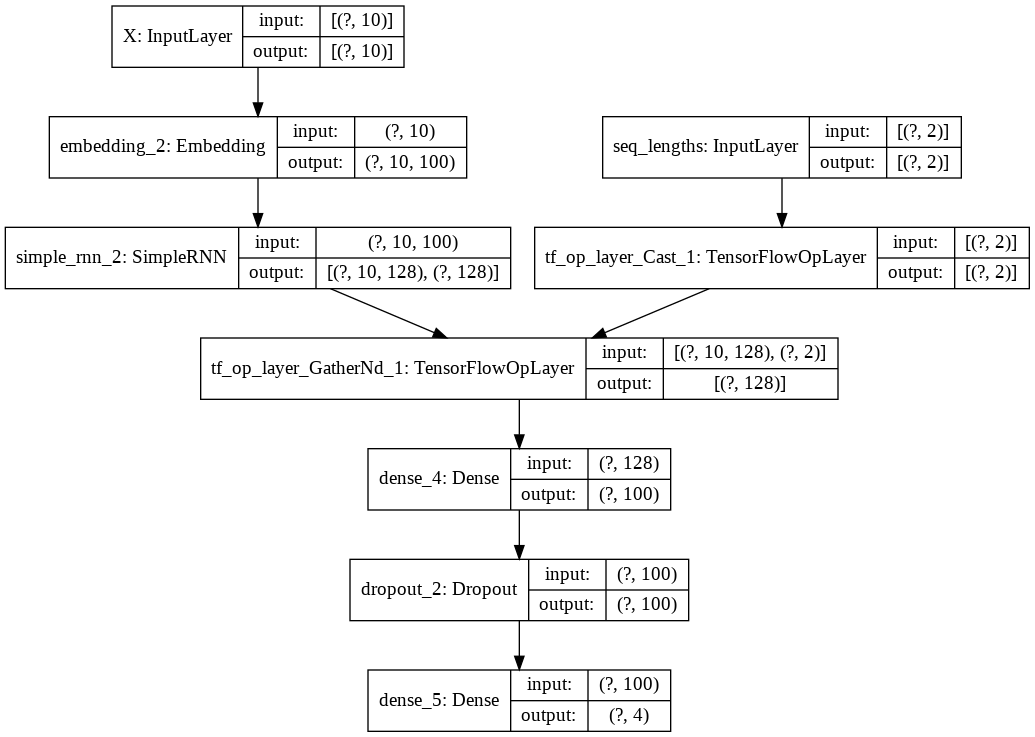

In [0]:
# Summary
model.summary(x_in_shape=(10,), seq_lengths_shape=(2,))

In our model, we want to use the RNN's output after the last relevant token in the sentence is processed. The last relevant token doesn't refer the <PAD> tokens but to the last actual word in the sentence and its index is different for each input in the batch.

This is why we included a `seq_lengths` variable in our `create_batch` function in the `Generator` class. The seq_lengths are passed in to the forward pass as an input and we use [tf.gather_nd](https://www.tensorflow.org/api_docs/python/tf/gather_nd) to gather the last relevant hidden state (before padding starts). 

```python
def create_batch(self, batch_indices):
    ...
    # Sequence lengths
    seq_lengths = np.array([[i, len(x)-1] for i, x in enumerate(X)])
    ...
    return [X, seq_lengths], y
```

Once we have the relevant hidden state extracted, we proceed to apply some fully-connected layers (with softmax) to generate the class probabilities.

## Training

In [0]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
%load_ext tensorboard

In [0]:
NUM_LAYERS = 1
LEARNING_RATE = 1e-3
EARLY_STOPPING_CRITERIA = 3
NUM_EPOCHS = 5

In [0]:
# Compile
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

In [0]:
# Callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_CRITERIA, verbose=1, mode='min'),
             ReduceLROnPlateau(patience=1, factor=0.1, verbose=0),
             TensorBoard(log_dir='tensorboard/simple_rnn', histogram_freq=1, update_freq='epoch')]

In [0]:
# Training
training_history = model.fit_generator(generator=training_generator,
                                       epochs=NUM_EPOCHS,
                                       validation_data=validation_generator,
                                       callbacks=callbacks,
                                       shuffle=False,
                                       class_weight=class_weights,
                                       verbose=1)

Epoch 1/5
339/339 [==============================] - 58s 170ms/step - loss: 5.7626e-05 - sparse_categorical_accuracy: 0.3150 - val_loss: 0.7964 - val_sparse_categorical_accuracy: 0.7154
Epoch 2/5
339/339 [==============================] - 59s 173ms/step - loss: 2.8695e-05 - sparse_categorical_accuracy: 0.7520 - val_loss: 0.4783 - val_sparse_categorical_accuracy: 0.8376
Epoch 3/5
339/339 [==============================] - 58s 171ms/step - loss: 1.9602e-05 - sparse_categorical_accuracy: 0.8548 - val_loss: 0.4265 - val_sparse_categorical_accuracy: 0.8516
Epoch 4/5
339/339 [==============================] - 58s 172ms/step - loss: 1.6127e-05 - sparse_categorical_accuracy: 0.8861 - val_loss: 0.4191 - val_sparse_categorical_accuracy: 0.8529
Epoch 5/5
339/339 [==============================] - 58s 170ms/step - loss: 1.3743e-05 - sparse_categorical_accuracy: 0.9032 - val_loss: 0.4064 - val_sparse_categorical_accuracy: 0.8581


In [0]:
# Evaluation
testing_history = model.evaluate_generator(generator=testing_generator, verbose=1)

71/71 [==============================] - 4s 61ms/step - loss: 0.3940 - sparse_categorical_accuracy: 0.8632


In [0]:
%tensorboard --logdir tensorboard

# Bidirectional RNN

We can also have RNNs that process inputs from both directions (first token to last token and vice versa) and combine their outputs. This architecture is known as a bidirectional RNN. 

In [0]:
from tensorflow.keras.layers import Bidirectional

In [0]:
class BiRNN(Model):
    def __init__(self, vocab_size, embedding_dim, rnn_cell, 
                 hidden_dim, dropout_p, num_classes):
        super(BiRNN, self).__init__(name="biRNN")

        # Embeddings
        self.embedding = Embedding(input_dim=vocab_size,
                                   output_dim=embedding_dim,
                                   mask_zero=True,
                                   trainable=True)
        
        # Masking
        self.mask = Masking(mask_value=0.)
        
        # RNN
        self.rnn = Bidirectional(rnn_cell, merge_mode='sum')
        
        # FC layers
        self.fc1 = Dense(units=hidden_dim, activation='relu')
        self.dropout = Dropout(rate=dropout_p)
        self.fc2 = Dense(units=num_classes, activation='softmax')

    def call(self, inputs, training=False):
        """Forward pass."""
        
        # Inputs
        x_in, seq_lengths = inputs

        # Embed
        x_emb = self.embedding(x_in)
        
        # Masking
        z = self.mask(x_emb)

        # RNN
        z, hidden_state_fw, hidden_state_bw = self.rnn(x_emb)

        # Gather last relevant index
        z = tf.gather_nd(z, K.cast(seq_lengths, 'int32'))

        # FC
        z = self.fc1(z)
        z = self.dropout(z, training=training)
        y_pred = self.fc2(z)

        return y_pred
    
    def summary(self, x_in_shape, seq_lengths_shape):
        x_in = Input(shape=x_in_shape, name='X')
        seq_lengths = Input(shape=seq_lengths_shape, name='seq_lengths')
        inputs = [x_in, seq_lengths]
        summary = Model(inputs=inputs, outputs=self.call(inputs), name=self.name)
        return plot_model(summary, show_shapes=True) # forward pass

In [0]:
# Simple RNN cell
simple_rnn = SimpleRNN(units=RNN_HIDDEN_DIM, 
                       dropout=DROPOUT_P, 
                       recurrent_dropout=RNN_DROPOUT_P,
                       return_sequences=True,
                       return_state=True)

In [0]:
# Initialize model
model = BiRNN(vocab_size=vocab_size,
              embedding_dim=EMBEDDING_DIM,
              rnn_cell=simple_rnn, # using simple rnn cell
              hidden_dim=HIDDEN_DIM,
              dropout_p=DROPOUT_P,
              num_classes=len(classes))

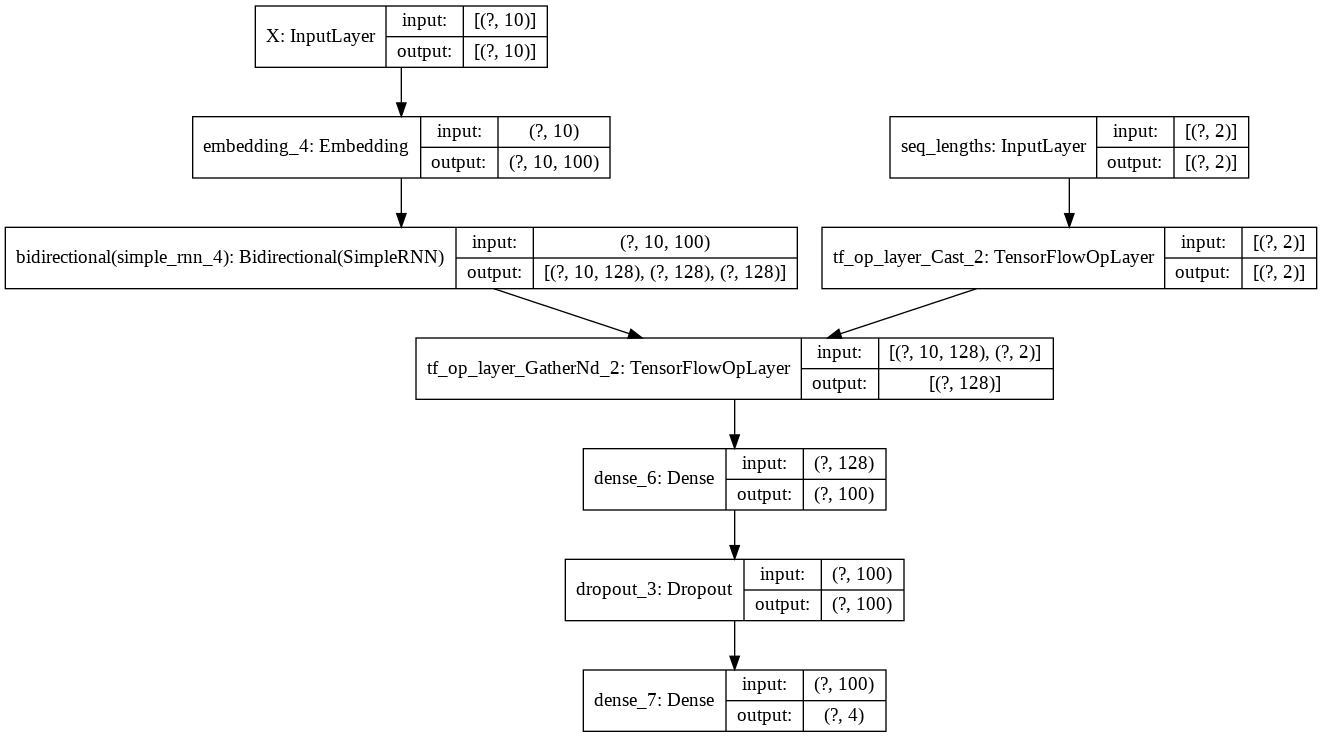

In [0]:
# Summary
model.summary(x_in_shape=(10,), seq_lengths_shape=(2,))

In [0]:
# Compile
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

In [0]:
# Callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_CRITERIA, verbose=1, mode='min'),
             ReduceLROnPlateau(patience=1, factor=0.1, verbose=0),
             TensorBoard(log_dir='tensorboard/simple_birnn', histogram_freq=1, update_freq='epoch')]

In [0]:
# Training
training_history = model.fit_generator(generator=training_generator,
                                       epochs=NUM_EPOCHS,
                                       validation_data=validation_generator,
                                       callbacks=callbacks,
                                       shuffle=False,
                                       class_weight=class_weights,
                                       verbose=1) 

Epoch 1/10
339/339 [==============================] - 100s 296ms/step - loss: 5.6063e-05 - sparse_categorical_accuracy: 0.3227 - val_loss: 0.7378 - val_sparse_categorical_accuracy: 0.7328
Epoch 2/10
339/339 [==============================] - 96s 283ms/step - loss: 2.7235e-05 - sparse_categorical_accuracy: 0.7649 - val_loss: 0.4763 - val_sparse_categorical_accuracy: 0.8361
Epoch 3/10
339/339 [==============================] - 95s 281ms/step - loss: 1.9202e-05 - sparse_categorical_accuracy: 0.8574 - val_loss: 0.4254 - val_sparse_categorical_accuracy: 0.8510
Epoch 4/10
339/339 [==============================] - 98s 289ms/step - loss: 1.5746e-05 - sparse_categorical_accuracy: 0.8858 - val_loss: 0.4090 - val_sparse_categorical_accuracy: 0.8575
Epoch 5/10
339/339 [==============================] - 97s 285ms/step - loss: 1.3364e-05 - sparse_categorical_accuracy: 0.9061 - val_loss: 0.4132 - val_sparse_categorical_accuracy: 0.8560
Epoch 6/10
339/339 [==============================] - 97s 286ms/

# Gated RNNs: LSTMs & GRUs

While our simple RNNs so far are great for sequentially processing our inputs, they have quite a few disadvantages. They commonly suffer from exploding or vanishing gradients as a result using the same set of weights ($W_{xh}$ and $W_{hh}$) with each timestep's input. During backpropagation, this can cause gradients to explode (>1) or vanish (<1). If you multiply any number greater than 1 with itself over and over, it moves towards infinity (exploding gradients) and similarly,  If you multiply any number less than 1 with itself over and over, it moves towards zero (vanishing gradients). To mitigate this issue, gated RNNs were devised to selectively retrain information. If you're interested in learning more of the specifics, this [post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is a must-read.

There are two popular types of gated RNNs: Long Short-term Memory (LSTMs) units and Gated Recurrent Units (GRUs).

<div align="left">
<img src="https://raw.githubusercontent.com/madewithml/images/master/basics/15_Recurrent_Neural_Networks/gated_rnns.png" width="600">
</div>
<a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/">Understanding LSTM Networks</a> - Chris Olah


**NOTE**: When deciding between LSTMs and GRUs, empirical performance is the best factor but in genreal GRUs offer similar performance with less complexity (less weights). 



In [0]:
from tensorflow.keras.layers import GRU

In [0]:
# RNN cell
gru = GRU(units=RNN_HIDDEN_DIM, 
          dropout=DROPOUT_P, 
          recurrent_dropout=RNN_DROPOUT_P,
          return_sequences=True,
          return_state=True) 

In [0]:
# Initialize model
model = BiRNN(vocab_size=vocab_size,
              embedding_dim=EMBEDDING_DIM,
              rnn_cell=gru, # use gru cell
              hidden_dim=HIDDEN_DIM,
              dropout_p=DROPOUT_P,
              num_classes=len(classes))

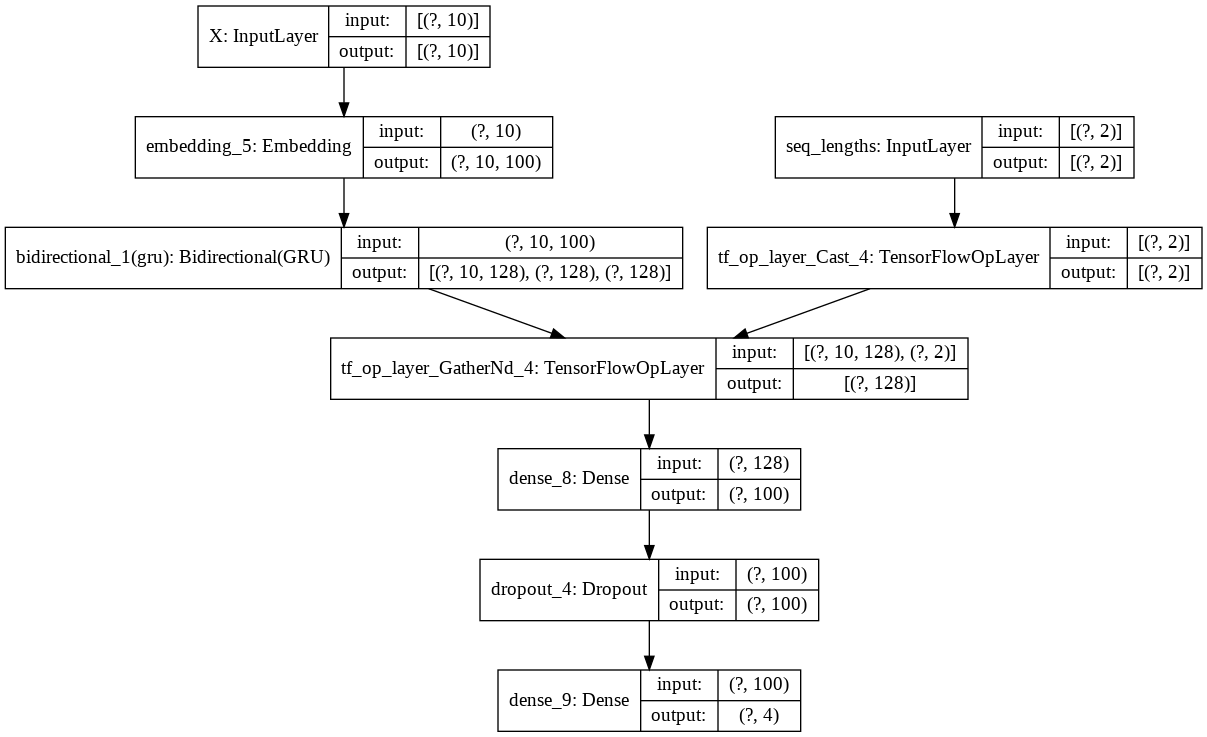

In [0]:
# Summary
model.summary(x_in_shape=(10,), seq_lengths_shape=(2,))

In [0]:
# Compile
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

In [0]:
# Callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_CRITERIA, verbose=1, mode='min'),
             ReduceLROnPlateau(patience=1, factor=0.1, verbose=0),
             TensorBoard(log_dir='tensorboard/gru', histogram_freq=1, update_freq='epoch')]

In [0]:
# Training
training_history = model.fit_generator(generator=training_generator,
                                       epochs=NUM_EPOCHS,
                                       validation_data=validation_generator,
                                       callbacks=callbacks,
                                       shuffle=False,
                                       class_weight=class_weights,
                                       verbose=1)

Epoch 1/10
339/339 [==============================] - 207s 610ms/step - loss: 6.3519e-05 - sparse_categorical_accuracy: 0.2851 - val_loss: 1.3547 - val_sparse_categorical_accuracy: 0.3324
Epoch 2/10
339/339 [==============================] - 210s 618ms/step - loss: 5.3265e-05 - sparse_categorical_accuracy: 0.4139 - val_loss: 0.7810 - val_sparse_categorical_accuracy: 0.7101
Epoch 3/10
339/339 [==============================] - 213s 629ms/step - loss: 2.6807e-05 - sparse_categorical_accuracy: 0.7586 - val_loss: 0.4960 - val_sparse_categorical_accuracy: 0.8286
Epoch 4/10
339/339 [==============================] - 217s 642ms/step - loss: 1.9131e-05 - sparse_categorical_accuracy: 0.8560 - val_loss: 0.4458 - val_sparse_categorical_accuracy: 0.8473
Epoch 5/10
339/339 [==============================] - 221s 652ms/step - loss: 1.5748e-05 - sparse_categorical_accuracy: 0.8913 - val_loss: 0.4224 - val_sparse_categorical_accuracy: 0.8532
Epoch 6/10
339/339 [==============================] - 215s 6

In [0]:
# Evaluation
testing_history = model.evaluate_generator(generator=testing_generator, verbose=1)

71/71 [==============================] - 14s 203ms/step - loss: 0.4063 - sparse_categorical_accuracy: 0.8605


In [0]:
%tensorboard --logdir tensorboard

Reusing TensorBoard on port 6006 (pid 401), started 0:51:45 ago. (Use '!kill 401' to kill it.)

# Evaluation

In [0]:
import io
import itertools
import json
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    """Plot a confusion matrix using ground truth and predictions."""
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #  Figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Axis
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    ax.set_xticklabels([''] + classes)
    ax.set_yticklabels([''] + classes)
    ax.xaxis.set_label_position('bottom') 
    ax.xaxis.tick_bottom()

    # Values
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:d} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Display
    plt.show()

In [0]:
def get_performance(y_true, y_pred, classes):
    """Per-class performance metrics."""
    performance = {'overall': {}, 'class': {}}
    y_pred = np.argmax(y_pred, axis=1)
    metrics = precision_recall_fscore_support(y_true, y_pred)

    # Overall performance
    performance['overall']['precision'] = np.mean(metrics[0])
    performance['overall']['recall'] = np.mean(metrics[1])
    performance['overall']['f1'] = np.mean(metrics[2])
    performance['overall']['num_samples'] = np.float64(np.sum(metrics[3]))

    # Per-class performance
    for i in range(len(classes)):
        performance['class'][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i])
        }

    return performance

In [0]:
# Evaluation
test_history = model.evaluate_generator(generator=testing_generator, verbose=1)
y_pred = model.predict_generator(generator=testing_generator, verbose=1)
print (f"test history: {test_history}")

71/71 [==============================] - 14s 201ms/step
test history: [0.40631949565779996, 0.8605]


In [0]:
# Class performance
performance = get_performance(y_true=y_test, y_pred=y_pred, classes=classes)
print (json.dumps(performance, indent=4))

{
    "overall": {
        "precision": 0.8608457987383706,
        "recall": 0.8604999999999999,
        "f1": 0.8605275947214777,
        "num_samples": 18000.0
    },
    "class": {
        "Business": {
            "precision": 0.8306023029229407,
            "recall": 0.8335555555555556,
            "f1": 0.8320763087843833,
            "num_samples": 4500.0
        },
        "Sci/Tech": {
            "precision": 0.826889661164205,
            "recall": 0.846,
            "f1": 0.836335676625659,
            "num_samples": 4500.0
        },
        "Sports": {
            "precision": 0.8991688538932633,
            "recall": 0.9135555555555556,
            "f1": 0.906305114638448,
            "num_samples": 4500.0
        },
        "World": {
            "precision": 0.8867223769730733,
            "recall": 0.8488888888888889,
            "f1": 0.8673932788374206,
            "num_samples": 4500.0
        }
    }
}


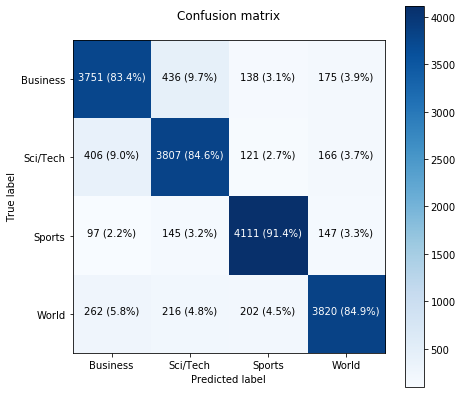

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      4500
           1       0.83      0.85      0.84      4500
           2       0.90      0.91      0.91      4500
           3       0.89      0.85      0.87      4500

    accuracy                           0.86     18000
   macro avg       0.86      0.86      0.86     18000
weighted avg       0.86      0.86      0.86     18000



In [0]:
# Confusion matrix
plt.rcParams["figure.figsize"] = (7,7)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred, classes=classes)
print (classification_report(y_test, y_pred))

# Inference

In [0]:
import collections

In [0]:
def get_probability_distribution(y_prob, classes):
    results = {}
    for i, class_ in enumerate(classes):
        results[class_] = np.float64(y_prob[i])
    sorted_results = {k: v for k, v in sorted(
        results.items(), key=lambda item: item[1], reverse=True)}
    return sorted_results

In [0]:
# Inputs
texts = ["This weekend the greatest tennis players will fight for the championship."]
num_samples = len(texts)
X_infer = np.array(X_tokenizer.texts_to_sequences(texts))
print (f"{texts[0]} \n\t→ {decode(X_infer[0], X_tokenizer)} \n\t→ {X_infer[0]}")
print (f"len(X_infer[0]): {len(X_infer[0])} characters")
y_filler = np.array([0]*num_samples)

This weekend the greatest tennis players will fight for the championship. 
	→ this weekend the greatest tennis players will fight for the championship 
	→ [ 261 2226   10 5941  916  388   64  232    5   10 1523]
len(X_infer[0]): 11 characters


In [0]:
# Inference data generator
inference_generator = DataGenerator(
    X=X_infer, y=y_filler, batch_size=BATCH_SIZE, shuffle=False)

In [0]:
# Predict
y_prob = model.predict_generator(generator=inference_generator, verbose=1)

1/1 [==============================] - 0s 49ms/step


In [0]:
# Results
results = []
for index in range(num_samples):
    results.append({
        'raw_input': texts[index],
        'preprocessed_input': decode(indices=X_infer[index], tokenizer=X_tokenizer),
        'tokenized_input': str(X_infer[index]),
        'probabilities': get_probability_distribution(y_prob[index], y_tokenizer.classes_)
                   })
print (json.dumps(results, indent=4))

[
    {
        "raw_input": "This weekend the greatest tennis players will fight for the championship.",
        "preprocessed_input": "this weekend the greatest tennis players will fight for the championship",
        "tokenized_input": "[ 261 2226   10 5941  916  388   64  232    5   10 1523]",
        "probabilities": {
            "Sports": 0.997166097164154,
            "World": 0.0028288678731769323,
            "Sci/Tech": 4.848130629397929e-06,
            "Business": 1.7172565947021212e-07
        }
    }
]


**NOTE**: We will learn how to get a little bit of interpretabiltiy with RNNs in the next lesson on attentional interfaces.

---
Share and discover ML projects at <a href="https://madewithml.com/">Made With ML</a>.

<div align="left">
<a class="ai-header-badge" target="_blank" href="https://github.com/madewithml/basics"><img src="https://img.shields.io/github/stars/madewithml/basics.svg?style=social&label=Star"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://www.linkedin.com/company/madewithml"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://twitter.com/madewithml"><img src="https://img.shields.io/twitter/follow/madewithml.svg?label=Follow&style=social"></a>
</div>
             